In [156]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.constants as c
from scipy import stats

from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from regions import Regions

import os
import sys
from astropy.table import Table, join, vstack
from astropy.nddata.utils import extract_array
import pyregion
import tqdm 
import argparse

import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=AstropyWarning, append=True)

import integratedflux_py3 as flux_py3
from importlib import reload
reload(flux_py3)

<module 'integratedflux_py3' from '/net/vdesk/data2/GoesaertW/Data_Analyis_Git/integratedflux_py3.py'>

In [213]:
path_sigma = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
fname_sigma = 'Abell_85_Fits_Data_Mean_Std_rmsynth'
hdu_sigma = fits.open(get_pkg_data_filename(path_sigma+fname_sigma+'.fits'))[0]
data_sigma = hdu_sigma.data

path_git = r'/net/vdesk/data2/GoesaertW/Data_Analyis_Git/'
rsl = fits.open(get_pkg_data_filename(path_git+'Abell85_catalog_BDSF_adapbox_rsl.fits'))[1].data
region_name = "Abell85_catalog_BDSF_adapbox_rsl.reg"
reg_file = Regions.read(region_name)

path_I = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
fname_I = 'Abell85_ch0_BDSF'
hdu_I = fits.open(get_pkg_data_filename(path_I+fname_I+'.fits'))[0]
data_I = hdu_I.data.squeeze()

path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_polint = 'rmsynth_polint_1'
hdu_polint = fits.open(get_pkg_data_filename(path_rmsynth+fname_polint+'.fits'))[0]
del hdu_polint.header['CROTA4']
data_polint = hdu_polint.data
wcs = WCS(hdu_polint.header)

In [214]:
sources_worldpos = np.array((rsl['RA'], rsl['DEC']))
sources_pixpos_floats = wcs.all_world2pix(rsl['RA'], rsl['DEC'], 0)
sources_pixpos = np.swapaxes(np.rint(sources_pixpos_floats\
                                     , out=np.zeros(np.shape(sources_worldpos)
                                     , int), casting='unsafe'),0,1)

sources_polint = data_polint[sources_pixpos[:,1], sources_pixpos[:,0]]
sources_sigma = data_sigma[sources_pixpos[:,1], sources_pixpos[:,0]]

polarized_mask = np.array((data_sigma>5), dtype=int)
mask_cube = np.zeros((1,1,3617,3617))
mask_cube[0,0,:,:] = polarized_mask
Fits_mask = fits.PrimaryHDU(mask_cube)
Fits_mask.header = hdu_polint.header
Fits_mask.writeto(path_git+'Linpol_5sigma.fits', overwrite=True)

print(len(rsl))

5572


In [203]:
reload(flux_py3)
name = path_git + 'Linpol_5sigma.fits'

Fits_mask = fits.open(name)
hdul_image_flat = flux_py3.flatten(Fits_mask)
source_num = len(rsl)

sigmalim_pixels = np.zeros(source_num)

for n in tqdm.tqdm(range(source_num)):
    measurement = flux_py3.integratedflux(name, reg_file, n, hdul=hdul_image_flat, convert=False, jansky=False)
    sigmalim_pixels[n] = measurement[0]
Fits_mask.close()

100%|██████████| 5572/5572 [00:46<00:00, 118.64it/s]


Text(0, 0.5, 'number of detection limits')

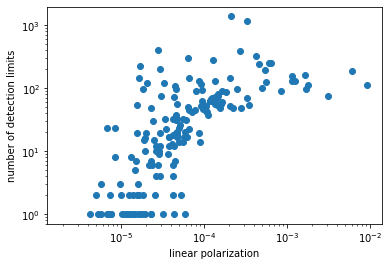

In [209]:
plt.scatter(sources_polint, sigmalim_pixels)
plt.xscale('log')
#plt.ylim(-1,30)
plt.yscale('log')
plt.xlabel('linear polarization')
plt.ylabel('number of detection limits')

In [210]:
sigmalim_mask = (sigmalim_pixels>=5)
print(len(np.nonzero(sigmalim_mask)[0]))

132


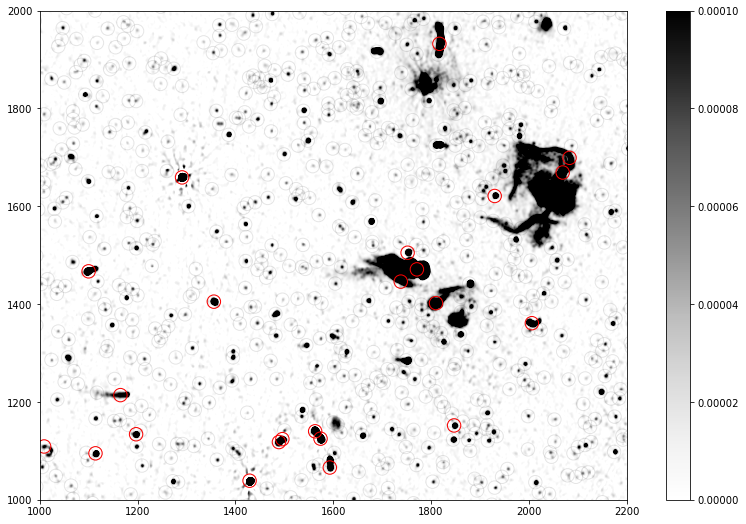

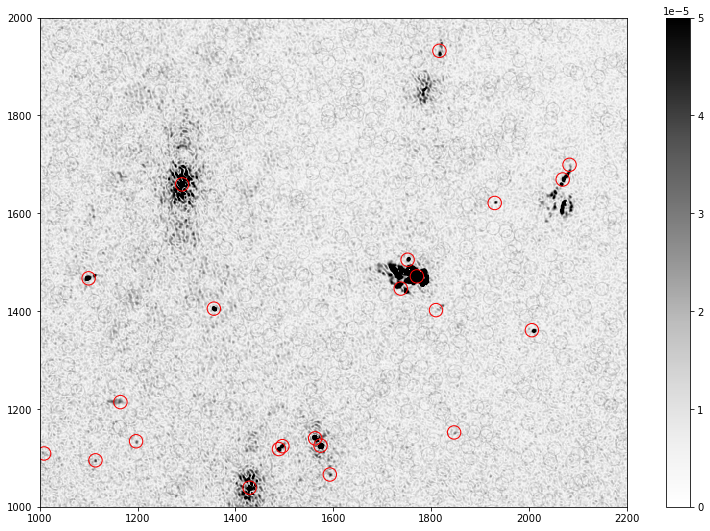

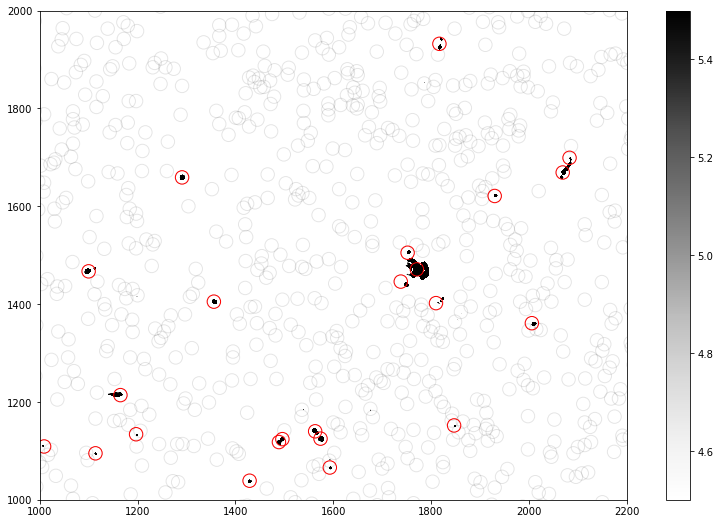

In [215]:
plt.figure(figsize=(14,9))
a = plt.imshow(data_I, vmin=0, vmax=1e-4, cmap='Greys', origin='lower', interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=180, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[sigmalim_mask,0], sources_pixpos[sigmalim_mask,1], s=180, facecolors='none', edgecolors='r')
plt.colorbar(a)
plt.xlim(1000,2200)
plt.ylim(1000,2000)
plt.show()

plt.figure(figsize=(14,9))
a = plt.imshow(data_polint, vmin=0, vmax=5e-5, cmap='Greys', origin='lower', interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=180, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[sigmalim_mask,0], sources_pixpos[sigmalim_mask,1], s=180, facecolors='none', edgecolors='r')
plt.colorbar(a)
plt.xlim(1000,2200)
plt.ylim(1000,2000)
plt.show()

plt.figure(figsize=(14,9))
a = plt.imshow(data_sigma, vmin=5, vmax=5, cmap='Greys', origin='lower', interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=180, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[sigmalim_mask,0], sources_pixpos[sigmalim_mask,1], s=180, facecolors='none', edgecolors='r')
plt.colorbar(a)
plt.xlim(1000,2200)
plt.ylim(1000,2000)
plt.show()


In [212]:
np.save(path_I+'Abell85_mask_5sigma10pix.npy', sigmalim_mask)